#### Constructing the dataset

In [24]:
import pandas as pd
import requests

# Setting chunk size for stock_prices
chunksize = 100000

# Processing stock prices data in chunks
all_stock_prices = []
for chunk in pd.read_csv('datasets/stock_prices_latest.csv', chunksize=chunksize, parse_dates=['date'] if 'date' in pd.read_csv('datasets/stock_prices_latest.csv', nrows=1).columns else [0], index_col=0 if 'date' not in pd.read_csv('datasets/stock_prices_latest.csv', nrows=1).columns else None, engine='python'):
    all_stock_prices.append(chunk)
stock_prices = pd.concat(all_stock_prices)

# Loading dividends and earnings data directly (no chunking)
dividends = pd.read_csv('datasets/dividends_latest.csv', parse_dates=['date'] if 'date' in pd.read_csv('datasets/dividends_latest.csv', nrows=1).columns else [0], index_col=0 if 'date' not in pd.read_csv('datasets/dividends_latest.csv', nrows=1).columns else None, engine='python')
earnings = pd.read_csv('datasets/earnings_latest.csv', parse_dates=['date'] if 'date' in pd.read_csv('datasets/earnings_latest.csv', nrows=1).columns else [0], index_col=0 if 'date' not in pd.read_csv('datasets/earnings_latest.csv', nrows=1).columns else None, engine='python')


print("Dividends Data:")
print(dividends.head())

print("\nEarnings Data:")
print(earnings.head())

print("\nStock Prices Data:")
print(stock_prices.head())


# Merging stock prices with dividends on a common column
merged_data = pd.merge(stock_prices, dividends, on=['symbol', 'date'], how='left')

# Merging with earnings data
merged_data = pd.merge(merged_data, earnings, on=['symbol', 'date'], how='left')

print(merged_data.head())

merged_data.columns

merged_data = merged_data[['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'eps_est', 'eps']]


# Fetching news data from the API
url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&apikey=M9HROIEL6ZIJXKPZ'
response = requests.get(url)
news_data = response.json()

# Converting articles to DataFrame
articles = news_data['feed']
news_df = pd.DataFrame(articles)

# Exploding the 'ticker_sentiment' column
news_df = news_df.explode('ticker_sentiment')

# Normalizing the 'ticker_sentiment' column to extract relevant ticker information
ticker_sentiments = pd.json_normalize(news_df['ticker_sentiment'])

# Concatenating the ticker data with the rest of the DataFrame
news_df = pd.concat([news_df.reset_index(drop=True), ticker_sentiments.reset_index(drop=True)], axis=1)

# Selecting relevant columns for aggregation
news_df_reduced = news_df[['time_published', 'ticker', 'overall_sentiment_label']]

# Converting 'time_published' to datetime for easier aggregation
news_df_reduced['time_published'] = pd.to_datetime(news_df_reduced['time_published'])

# Aggregating by date and ticker
aggregated_sentiments = news_df_reduced.groupby(
    [news_df_reduced['time_published'].dt.date, 'ticker']
).agg({
    'overall_sentiment_label': lambda x: x.mode()[0] if not x.empty else 'neutral'  # Most common sentiment
}).reset_index()

# Renaming columns for clarity
aggregated_sentiments.rename(columns={'time_published': 'date'}, inplace=True)

# Displaying the aggregated sentiments
print(aggregated_sentiments.head())

Dividends Data:
  symbol       date  dividend
0   MSFT 2016-11-15      0.39
1   MSFT 2011-05-17      0.16
2   MSFT 2008-05-13      0.11
3   MSFT 2011-02-15      0.16
4   MSFT 2012-02-14      0.20

Earnings Data:
  symbol       date      qtr  eps_est  eps release_time
0      A 2009-05-14  04/2009      NaN  NaN         post
1      A 2009-08-17  07/2009      NaN  NaN         post
2      A 2009-11-13  10/2009      NaN  NaN          pre
3      A 2010-02-12  01/2010      NaN  NaN          pre
4      A 2010-05-17  04/2010      NaN  NaN         post

Stock Prices Data:
  symbol       date   open   high    low  close  close_adjusted     volume  \
0   MSFT 2016-05-16  50.80  51.96  50.75  51.83         49.7013   20032017   
1   MSFT 2002-01-16  68.85  69.84  67.85  67.87         22.5902   30977700   
2   MSFT 2001-09-18  53.41  55.00  53.17  54.32         18.0802   41591300   
3   MSFT 2007-10-26  36.01  36.03  34.56  35.03         27.2232  288121200   
4   MSFT 2014-06-27  41.61  42.29  41.51  

/var/folders/v5/p9v3ggy96jjd2hvcgg6v78kh0000gn/T/ipykernel_51505/942982593.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df_reduced['time_published'] = pd.to_datetime(news_df_reduced['time_published'])


In [26]:
# Defining the mapping for sentiment labels
sentiment_mapping = {
    'neutral': 0,
    'somewhat-bullish': 1,
    'bullish': 2,
    'somewhat-bearish': -1,
    'bearish': -2
}

# Applying the mapping to create a new column
aggregated_sentiments['sentiment_score'] = aggregated_sentiments['overall_sentiment_label']\
    .str.lower().map(sentiment_mapping)

# Dropping the text label
aggregated_sentiments.drop(columns=['overall_sentiment_label'], inplace=True)

print(aggregated_sentiments.head())

         date ticker  sentiment_score
0  2025-04-14   ABBV                1
1  2025-04-14   ALGM                2
2  2025-04-14   AMAT                1
3  2025-04-14    APA                1
4  2025-04-14    APG                0


In [28]:
# Renaming and aligning columns in aggregated_sentiments for merging
aggregated_sentiments.rename(columns={'ticker': 'symbol', 'time_published': 'date'}, inplace=True)

# Converting 'date' columns to datetime format
merged_data['date'] = pd.to_datetime(merged_data['date'])
aggregated_sentiments['date'] = pd.to_datetime(aggregated_sentiments['date'])

merged_data.shape

(24395016, 10)

In [30]:
# Breaking merged_data into smaller chunks
chunk_size = 10000
chunks = [merged_data[i:i + chunk_size] for i in range(0, merged_data.shape[0], chunk_size)]

processed_chunks = []

# Process each chunk
for chunk in chunks:
    chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce')
    aggregated_sentiments['date'] = pd.to_datetime(aggregated_sentiments['date'], errors='coerce')

    # Perform the merge
    chunk_result = chunk.merge(
        aggregated_sentiments[['symbol', 'date', 'sentiment_score']],
        on=['date', 'symbol'],  # Using 'date' and 'symbol' as keys for merging
        how='left'  # Using 'left' join to keep all rows from merged_data
    )

    processed_chunks.append(chunk_result)

# Combining all processed chunks into a single DataFrame
final_merged_data = pd.concat(processed_chunks, ignore_index=True)

print(final_merged_data.head())

/var/folders/v5/p9v3ggy96jjd2hvcgg6v78kh0000gn/T/ipykernel_51505/240156424.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce')
/var/folders/v5/p9v3ggy96jjd2hvcgg6v78kh0000gn/T/ipykernel_51505/240156424.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce')
/var/folders/v5/p9v3ggy96jjd2hvcgg6v78kh0000gn/T/ipykernel_51505/240156424.py:9: SettingWithCopyWarning: 
A value is trying to be se

  symbol       date   open   high    low  close     volume  dividend  eps_est  \
0   MSFT 2016-05-16  50.80  51.96  50.75  51.83   20032017       NaN      NaN   
1   MSFT 2002-01-16  68.85  69.84  67.85  67.87   30977700       NaN      NaN   
2   MSFT 2001-09-18  53.41  55.00  53.17  54.32   41591300       NaN      NaN   
3   MSFT 2007-10-26  36.01  36.03  34.56  35.03  288121200       NaN      NaN   
4   MSFT 2014-06-27  41.61  42.29  41.51  42.25   74640000       NaN      NaN   

   eps  sentiment_score  
0  NaN              NaN  
1  NaN              NaN  
2  NaN              NaN  
3  NaN              NaN  
4  NaN              NaN  


In [32]:
for i, chunk in enumerate(processed_chunks):
    chunk.to_csv('final_dataset_merged.csv', index=False, mode='a', header=(i == 0))

In [34]:
final_merged_data.columns

Index(['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend',
       'eps_est', 'eps', 'sentiment_score'],
      dtype='object')

In [36]:
print(final_merged_data.describe())

                                date          open          high  \
count                       24395016  2.439502e+07  2.439502e+07   
mean   2012-01-15 09:42:18.302479872  6.623594e+01  6.686430e+01   
min              1998-01-02 00:00:00 -2.000000e-02 -2.000000e-02   
25%              2007-01-23 00:00:00  7.620000e+00  7.770000e+00   
50%              2013-02-19 00:00:00  1.714000e+01  1.740000e+01   
75%              2017-08-11 00:00:00  3.365000e+01  3.410000e+01   
max              2021-06-14 00:00:00  4.410630e+05  4.450000e+05   
std                              NaN  2.711679e+03  2.728914e+03   

                low         close        volume       dividend        eps_est  \
count  2.439502e+07  2.439502e+07  2.439502e+07  258917.000000  108818.000000   
mean   6.557013e+01  1.267143e+02  1.028882e+06       0.247393       0.200627   
min   -2.000000e-02 -2.000000e-02  0.000000e+00       0.000100   -4489.290000   
25%    7.470000e+00  7.620000e+00  1.950000e+04       0.065000 

#### XG-Boost model and visualizations

5002
5002
XGBoost Performance:
RMSE: 8.2785
MAE: 0.9417
R² Score: 0.9639


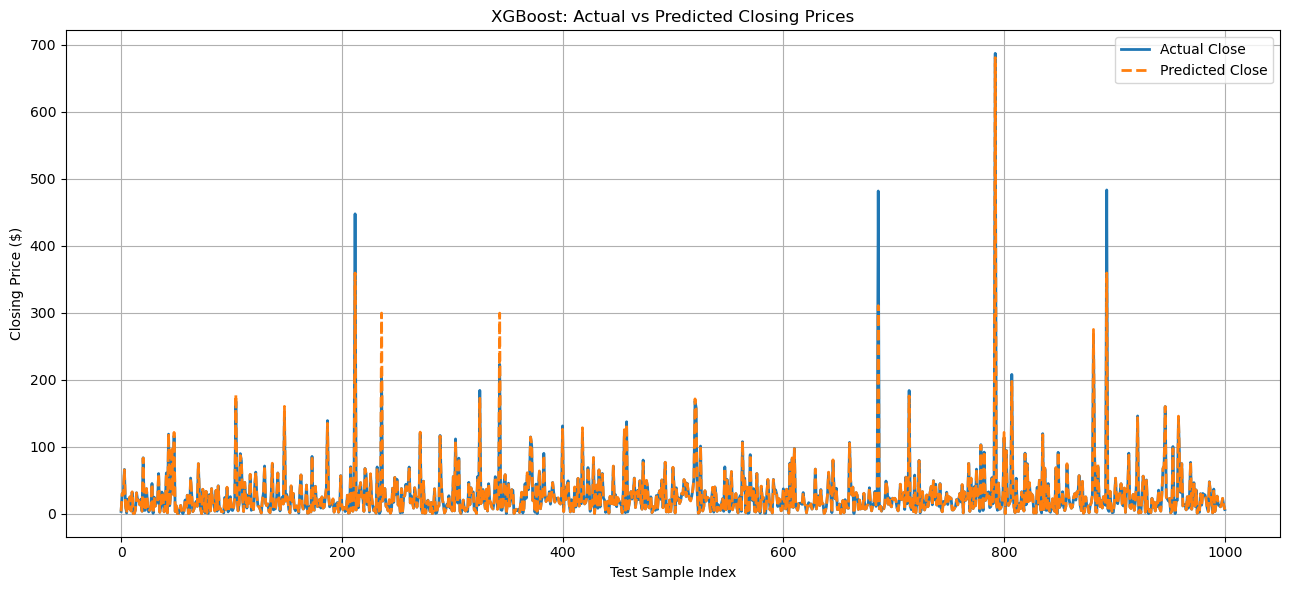

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np

df = pd.read_csv("final_dataset_merged.csv")

df = df.sample(n=5002, random_state=42)

df = df[['open', 'high', 'low', 'close', 'volume']]

X = df[['open', 'high', 'low', 'volume']]
y = df['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the model
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.5,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Performance:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR² Score: {r2:.4f}")

plt.figure(figsize=(13, 6))
plt.plot(y_test.values, label='Actual Close', linewidth=2)
plt.plot(y_pred, label='Predicted Close', linestyle='--', linewidth=2)
plt.title('XGBoost: Actual vs Predicted Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### LSTM

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.2302e-04 - val_loss: 2.1061e-06
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.8676e-04 - val_loss: 3.9141e-07
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.3197e-04 - val_loss: 4.4993e-06
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 8.9819e-04 - val_loss: 1.5476e-07
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.5637e-04 - val_loss: 1.0071e-04
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.0795e-04 - val_loss: 6.4033e-06
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.2597e-04 - val_loss: 1.0618e-07
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.4348e-04 - val_loss: 9.2709e-08
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0012 - val_loss: 6.7256e-08
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.6203e-04 - val_loss: 9.6470e-08
Epoch 11/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.

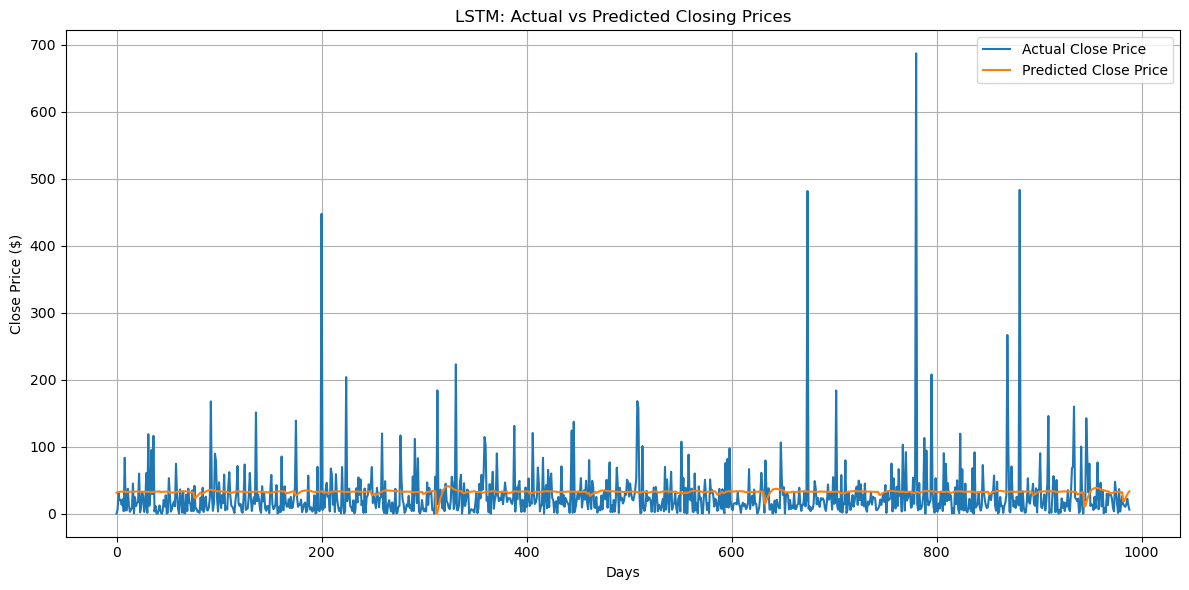

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv("final_dataset_merged.csv")

df = df.sample(n=5002, random_state=42)

feature_cols = ['open', 'low', 'high', 'volume']
target_col = 'close'

# Convert to numeric and drop rows with NaNs
df[feature_cols + [target_col]] = df[feature_cols + [target_col]].apply(pd.to_numeric, errors='coerce')
# df.dropna(inplace=True)

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features = feature_scaler.fit_transform(df[feature_cols])
scaled_target = target_scaler.fit_transform(df[[target_col]])

# Sequence creation
def create_sequences(X, y, seq_len=60):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 60
X, y = create_sequences(scaled_features, scaled_target, sequence_length)

# Train/test split
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Inverse transform predictions
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"\n📈 LSTM Performance (Predicting Closing Price):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Close Price')
plt.plot(y_pred, label='Predicted Close Price')
plt.title('LSTM: Actual vs Predicted Closing Prices')
plt.xlabel("Days")
plt.ylabel("Close Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()